# Convolutional Neural Nets

**Name:** Poorwa Hirve

<b> Objective- </b>

In this assignment, you will create and train a convolutional network using our automatic differentiation framework. There are two major tasks:
1. Implement a simple but useful convolutional layer within our automatic differentiation framework. The layer won't support padding and will only permit a stride of 1. Your implementation will not make use of the Toeplitz matrix (which converts convolution into a matrix multiplication). Instead, it will convolve the filter over the input tensor. With NumPy, this can be slow, so your implementation will make use of a just-in-time (JIT) NumPy acceleration library called Numba.
2. Construct and train a convolutional network similar to LeNet, using our automatic differentiation framework, to classify digits. To keep training times low, the dataset you'll use is a subset of the MNIST dataset that includes only subsets of the digits 3, 7, 8, and 9 -- which tend to be near one another in the learned representation space.

<b> Files provided- </b>
1. **functions.py** - Contains the definition of functions supported by auto-diff framework. No change is required in this file.
2. **utils.py**      - Contains utilities for auto-diff framework. No change is required in this file.
3. **tensor.py**    - Contains the Tensor wrapper class. Two additional functions have been added to the Tensor class, *conv2d and reshape*, you will provide a definition for these operations in the file conv_functions.py. No change is required in this file.
4. **np_utils.py** - Contains an example for accelerated version of rot180 (i.e. np.rot90 applied twice). You may add additional helper functions or use the given function if it helps.

<b> Files to be modified - </b>
1. **conv_functions.py** - Contains the definition of Convolution2D and Reshape operations added to the Tensor class. The first major task is to implement these two classes. Please look into the file for additional details.
2. **assignment_7.ipynb** - Contains unit tests for your implementation of Convolution2D and Reshape operations. Additionally you will implement a network similar to LeNet.
 


<b> Notes for Task 1 </b>
* You are free to implement the forward and backward pass for convolution operation as you see fit.
* If you find that the implementation is time consuming, you can use Numba to accelerate it. More information about Numba can be found here - http://numba.pydata.org/
    * Some key details on Numba :
        * All you need to numba-fy your function is to add a decorator to it. Please refer the example_helper_func given in conv_functions.py.
        * Numba doesn't understand the *self* argument, so ensure that your accelerated functions do not have *self* as an argument.
        * While Numba supports most NumPy functions, some of them (that you might need, ex: np.pad, np.rot90) are not supported. Please refer https://numba.pydata.org/numba-doc/dev/reference/numpysupported.html for more information.
        * With Numba, it takes about 60-90 seconds to pass the unit tests.
* Stride and Padding are defaulted to 1 and 0 respectively and are only included to keep an extensible interface, you won't use them in your implementation (unless you want to support arbitrary stride/padding)
* In the unit tests, your implementation is tested against PyTorch's. Please refer https://pytorch.org/docs/stable/nn.html for documentation.

<b> Notes for Task 2 </b>
* You will use the newly integrated conv2d layers to create a LeNet style network, The task is to classify a subset of MNIST digits. The dataset contains digits 3, 7, 8, 9 of size 1x21x21. It has 4k training examples and 1k validation examples.
* You may use the following configuration for your LeNet style network - 
    * Kernel for first conv layer: number of filters = 2, kernel size = (1, 6, 6), ReLU activation
    * Kernel for second conv layer: number of filters = 8, kernel size = (2, 6, 6), ReLU activation
    * Out size for first fully connected layer = 100, ReLU activation
    * Out size for output fully connected layer = 4, sigmoid activation
    * MSE loss between one-hot encoded true labels and predictions.
* You are free to use the entire dataset if you have enough compute, but are not required to do so. 
* The idea is to use simple, already implemented blocks to form the network, even if it might not be the best design choice (e.g. sigmoid instead of softmax at output, MSE loss instead of cross entropy loss, absence of pooling layers, etc.). You are free to add operations within the AD framework if you want to try out something new. Please share your tested implementation on Piazza if you do so!

# Part 1


Implement the convolutional layer within your automatic differentiation framework with no padding and a fixed stride of 1.

In [1]:
import numpy as np
import math
from functions import Function
import unittest
import torch
from tensor import Tensor
import time
from numba import jit
import np_utils
import copy
import pickle
import gzip
import matplotlib.pyplot as plt
from conv_functions import *
from sklearn.utils import shuffle
%matplotlib inline

In [2]:
class ConvTests(unittest.TestCase):

    def setUp(self):
        self._started_at = time.time()

    def tearDown(self):
        elapsed = time.time() - self._started_at
        print('{} ({}s)'.format(self.id(), round(elapsed, 2)))

    def test_forward_1(self):
        a = np.random.rand(50, 1, 50, 50)
        b = np.random.rand(20, 1, 2, 2)
        # Implementation
        result_1 = Tensor(a).conv2d(Tensor(b)).value
        # Torch
        result_2 = torch.nn.functional.conv2d(torch.tensor(a), torch.tensor(b), stride=1).numpy()

        self.assertEqual(np.allclose(result_1, result_2), True)

    def test_forward_2(self):
        a = np.random.rand(50, 1, 28, 28)
        b = np.random.rand(50, 1, 3, 4)
        # Implementation
        result_1 = Tensor(a).conv2d(Tensor(b)).value
        # Torch
        result_2 = torch.nn.functional.conv2d(torch.tensor(a), torch.tensor(b), stride=1).numpy()

        self.assertEqual(np.allclose(result_1, result_2), True)

    def test_forward_3(self):
        a = np.random.rand(20, 3, 28, 30)
        b = np.random.rand(50, 3, 4, 4)
        # Implementation
        result_1 = Tensor(a).conv2d(Tensor(b)).value
        # Torch
        result_2 = torch.nn.functional.conv2d(torch.tensor(a), torch.tensor(b), stride=1).numpy()

        self.assertEqual(np.allclose(result_1, result_2), True)

    def test_backward_1(self):
        a = np.random.rand(50, 2, 30, 30)
        b = np.random.rand(20, 2, 2, 2)
        # Implementation
        inp_1 = Tensor(a)
        kernel_1 = Tensor(b)
        res_1 = inp_1.conv2d(kernel_1)
        mse_1 = res_1.sum()
        mse_1.backward()
        # Torch
        inp_2 = torch.tensor(a, requires_grad=True)
        kernel_2 = torch.tensor(b, requires_grad=True)
        res_2 = torch.nn.functional.conv2d(inp_2, kernel_2, stride=1)
        mse_2 = torch.sum(res_2)
        mse_2.backward()

        self.assertEqual(np.allclose(inp_1.grad, inp_2.grad.numpy()), True)
        self.assertEqual(np.allclose(kernel_1.grad, kernel_2.grad.numpy()), True)

    def test_backward_2(self):
        a = np.random.rand(3, 1, 3, 3)
        b = np.random.rand(2, 1, 2, 2)
        # Implementation
        inp_1 = Tensor(a)
        kernel_1 = Tensor(b)
        res_1 = inp_1.conv2d(kernel_1)
        y_1 = Tensor(np.ones_like(res_1.value))
        mse_1 = (y_1 - res_1).pow(2).sum()
        mse_1.backward()
        # Torch
        inp_2 = torch.tensor(a, requires_grad=True)
        kernel_2 = torch.tensor(b, requires_grad=True)
        res_2 = torch.nn.functional.conv2d(inp_2, kernel_2, stride=1)
        y_2 = torch.tensor(np.ones_like(res_2.data))
        mse_2 = torch.sum((y_2 - res_2) ** 2)
        mse_2.backward()

        self.assertEqual(np.allclose(inp_1.grad, inp_2.grad.numpy()), True)
        self.assertEqual(np.allclose(kernel_1.grad, kernel_2.grad.numpy()), True)

    def test_backward_3(self):
        a = np.random.rand(4, 3, 20, 20)
        b = np.random.rand(10, 3, 3, 4)
        # Implementation
        inp_1 = Tensor(a)
        kernel_1 = Tensor(b)
        res_1 = inp_1.conv2d(kernel_1)
        y_1 = Tensor(np.ones_like(res_1.value))
        mse_1 = (y_1 - res_1).pow(2).sum()
        mse_1.backward()
        # Torch
        inp_2 = torch.tensor(a, requires_grad=True)
        kernel_2 = torch.tensor(b, requires_grad=True)
        res_2 = torch.nn.functional.conv2d(inp_2, kernel_2, stride=1)
        y_2 = torch.tensor(np.ones_like(res_2.data))
        mse_2 = torch.sum((y_2 - res_2) ** 2)
        mse_2.backward()

        self.assertEqual(np.allclose(inp_1.grad, inp_2.grad.numpy()), True)
        self.assertEqual(np.allclose(kernel_1.grad, kernel_2.grad.numpy()), True)

    def test_layers_4(self):
        a = np.random.rand(2, 2, 8, 8)
        b = np.random.rand(3, 2, 4, 4)
        c = np.random.rand(4, 3, 2, 2)
        # Implementation
        inp_1 = Tensor(a)
        kernel_1 = Tensor(b)
        kernel_11 = Tensor(c)
        res_1 = inp_1.conv2d(kernel_1)
        res_11 = res_1.conv2d(kernel_11)
        y_1 = Tensor(np.ones_like(res_11.value))
        mse = (y_1 - res_11).pow(2).sum()
        mse.backward()
        # Torch
        inp_2 = torch.tensor(a, requires_grad=True)
        kernel_2 = torch.tensor(b, requires_grad=True)
        kernel_22 = torch.tensor(c, requires_grad=True)
        res_2 = torch.nn.functional.conv2d(inp_2, kernel_2, stride=1)
        res_22 = torch.nn.functional.conv2d(res_2, kernel_22, stride=1)
        y_2 = torch.tensor(np.ones_like(res_22.data))
        mse = torch.sum((y_2 - res_22) ** 2)
        mse.backward()

        self.assertEqual(np.allclose(inp_1.grad, inp_2.grad.numpy()), True)
        self.assertEqual(np.allclose(kernel_1.grad, kernel_2.grad.numpy()), True)
        self.assertEqual(np.allclose(kernel_11.grad, kernel_22.grad.numpy()), True)

    def test_time(self):
        a = np.random.rand(100, 1, 28, 28)
        b = np.random.rand(20, 1, 14, 14)
        c = np.random.rand(30, 20, 7, 7)
        # Implementation
        inp_1 = Tensor(a)
        kernel_1 = Tensor(b)
        kernel_11 = Tensor(c)
        res_1 = inp_1.conv2d(kernel_1)
        res_11 = res_1.conv2d(kernel_11)
        y_1 = Tensor(np.ones_like(res_11.value))
        mse_1 = (y_1 - res_11).pow(2).sum()
        mse_1.backward()
        # Torch
        inp_2 = torch.tensor(a, requires_grad=True)
        kernel_2 = torch.tensor(b, requires_grad=True)
        kernel_22 = torch.tensor(c, requires_grad=True)
        res_2 = torch.nn.functional.conv2d(inp_2, kernel_2, stride=1)
        res_22 = torch.nn.functional.conv2d(res_2, kernel_22, stride=1)
        y_2 = torch.tensor(np.ones_like(res_22.data))
        mse_2 = torch.sum((y_2 - res_22) ** 2)
        mse_2.backward()

        self.assertEqual(np.allclose(inp_1.grad, inp_2.grad.numpy()), True)
        self.assertEqual(np.allclose(kernel_1.grad, kernel_2.grad.numpy()), True)
        self.assertEqual(np.allclose(kernel_11.grad, kernel_22.grad.numpy()), True)

    def test_reshape(self):
        a = np.random.rand(2, 4, 3, 3)
        b = np.random.rand(72, 1)
        # Implementation
        inp_1 = Tensor(a)
        inp_11 = Tensor(b)
        reshape_1 = inp_1.reshape(b.shape)
        loss_1 = (inp_11 + reshape_1).sum()
        loss_1.backward()
        # Torch
        inp_2 = torch.tensor(a, requires_grad=True)
        inp_22 = torch.tensor(b, requires_grad=True)
        reshape_2 = torch.sum(inp_2.view(b.shape) + inp_22)
        reshape_2.backward()

        self.assertEqual(np.allclose(inp_1.grad, inp_2.grad.numpy()), True)
        self.assertEqual(np.allclose(inp_11.grad, inp_22.grad.numpy()), True)


In [3]:
if __name__ == '__main__':
    unittest.main(argv=['first-arg-is-ignored'], exit=False)

.

__main__.ConvTests.test_backward_1 (10.34s)


.

__main__.ConvTests.test_backward_2 (0.26s)


.

__main__.ConvTests.test_backward_3 (0.44s)


.

__main__.ConvTests.test_forward_1 (0.74s)


.

__main__.ConvTests.test_forward_2 (0.52s)


.

__main__.ConvTests.test_forward_3 (0.58s)


..

__main__.ConvTests.test_layers_4 (0.5s)
__main__.ConvTests.test_reshape (0.0s)


.

__main__.ConvTests.test_time (11.69s)



----------------------------------------------------------------------
Ran 9 tests in 25.073s

OK


# Part 2


Create a CNN similar to LeNet to classify digits in a reduced MNIST dataset, Plot the training error and validation accuracy against epochs.

In [4]:
class ConvNetwork:
    def __init__(self):
        """
        Initialize convolutional and fully connected weights here.
        Kaiming weight initialization works well for the model.
        """
        self.kernel1 = Tensor(np.random.normal(0, math.sqrt(2.0 / 36), (2,1,6,6)))
        self.kernel2 = Tensor(np.random.normal(0, math.sqrt(2.0 / 72),(8,2,6,6)))
        self.W1 = Tensor(np.random.normal(0, math.sqrt(2.0 / 96800), (968,100)))
        self.W2 = Tensor(np.random.normal(0, math.sqrt(2.0 / 400), (100,4)))

    def forward(self, input_in):
        """
        Forward pass of the network.
        :param input_in: Input tensor of size (batch_size x in_channels x height x width).
        :return: output tensor (batch_size x out_size).
        """
        conv1 = input_in.conv2d(self.kernel1)
        conv1 = conv1.relu()
        conv2 = conv1.conv2d(self.kernel2)
        conv2 = conv2.relu()
        
        (batch_size, in_channels, height, width) = conv2.value.shape
        features = in_channels * height * width
                
        flatten = conv2.reshape((batch_size, features))
        a1 = flatten.dot(self.W1).relu()
        a2 = a1.dot(self.W2).sigmoid() 
                
        return a2

    def update(self, lr):
        """
        Update the weights of the network using SGD.
        """
        self.kernel1.value = self.kernel1.value - lr*self.kernel1.grad
        self.kernel2.value = self.kernel2.value - lr*self.kernel2.grad
        self.W1.value = self.W1.value - lr*self.W1.grad
        self.W2.value = self.W2.value - lr*self.W2.grad
    
    def zero_grad(self):
        """
        Reset gradients for the weights of the network.
        """
        self.kernel1.zero_grad()
        self.kernel2.zero_grad()
        self.W1.zero_grad()
        self.W2.zero_grad()

In [5]:
def test(model, X, y):
    """
    Test the model
    :param model: Trained ConvNetwork object.
    :param X: Validation set inputs.
    :param y: Validation set targets.
    :return: Accuracy of model.
    """
    batch_size = y.value.shape[0]
    
    X = X.reshape((batch_size, 1, 21, 21))
    y_hat = model.forward(X)
    
    accuracy = 0
    
    for i in range(batch_size):
        max_index = y_hat.value[i].argmax()
        accuracy += y.value[i][max_index]
     
    return accuracy/batch_size

In [6]:
def train(model, X, y, X_valid, y_valid, epochs, batch_size):
    """
    Train the model and validate it every few epochs.
    :param model: ConvNetwork object.
    :param X: Training set inputs.
    :param y: Training set targets.
    :param X_valid: Validation set inputs.
    :param y_valid: Validation set targets.
    :return: Training error for every epoch.
    :return: Validation accuracy every few epochs.
    """
    error_list = []
    accuracy_list = []
    batches = int(X.shape[0] / batch_size)
    
    for epoch in range(epochs):
        X, y = shuffle(X, y)
        error = []
        for i in range(0, X.shape[0], batch_size):
            X_batch = Tensor(X[i:i+batch_size])
            X_batch = X_batch.reshape((batch_size,1,21,21))
            
            y_batch = Tensor(y[i:i+batch_size])
            
            y_hat = model.forward(X_batch)
            model.zero_grad()
            mse = (y_batch - y_hat).pow(2).mean()
            error.append(mse.value)

            mse.backward()

            model.update(0.1)
            
        error_list.append(sum(error) / batches)
        accuracy_list.append(test(model, Tensor(X_valid), Tensor(y_valid)))
        print (epoch+1, '\t', '%.4f' % error_list[-1][0], '\t', accuracy_list[-1])
        
    return error_list, accuracy_list

In [7]:
def view_digit(x, label=None):
    """
    Utility function to view the training data.
    (courtesy - Chris Ketelsen)
    """
    fig = plt.figure(figsize=(3, 3))
    plt.imshow(x.reshape(21, 21), cmap='gray');
    plt.xticks([]);
    plt.yticks([]);
    if label:
        plt.xlabel("true: {}".format(label), fontsize=16)
    plt.show()

In [8]:
# Load the data into training and validation sets.
X_train, y_train, X_valid, y_valid = pickle.load(gzip.open("data/mnist21x21_3789_one_hot.pklz", "rb"))

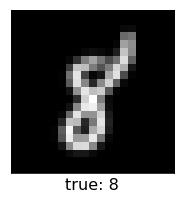

In [9]:
# View the training data.
training_index = 5
label_dict = dict({0: 3, 1: 7, 2: 8, 3: 9})
view_digit(X_train[training_index], label_dict[np.argmax(y_train[training_index])])

In [10]:
# Train and validate the network
network = ConvNetwork()

num_train = 4000
num_valid = 1000
epochs = 20
batch_size = 100

print ("Epoch \t Train Error \t Validation Accuracy")
print ("-------------------------------------------")
_started_at = time.time()
train_error, valid_acc = train(network, X_train[:num_train], y_train[:num_train], X_valid[:num_valid], y_valid[:num_valid], epochs, batch_size)
elapsed = time.time() - _started_at
print('({}s)'.format(round(elapsed, 2)))

Epoch 	 Train Error 	 Validation Accuracy
-------------------------------------------
1 	 0.1123 	 0.882
2 	 0.0438 	 0.917
3 	 0.0326 	 0.927
4 	 0.0277 	 0.935
5 	 0.0249 	 0.938
6 	 0.0214 	 0.945
7 	 0.0207 	 0.944
8 	 0.0180 	 0.947
9 	 0.0171 	 0.948
10 	 0.0157 	 0.952
11 	 0.0146 	 0.935
12 	 0.0141 	 0.952
13 	 0.0123 	 0.956
14 	 0.0118 	 0.957
15 	 0.0110 	 0.951
16 	 0.0106 	 0.954
17 	 0.0103 	 0.962
18 	 0.0093 	 0.959
19 	 0.0093 	 0.949
20 	 0.0085 	 0.96
(2223.36s)


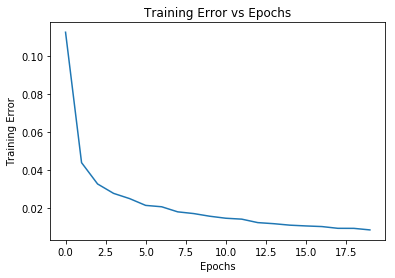

In [11]:
# Plot training error.
plt.plot(range(epochs), train_error)
plt.xlabel("Epochs")
plt.ylabel("Training Error")
plt.title("Training Error vs Epochs")
plt.show()

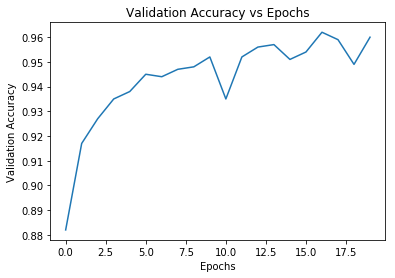

In [12]:
# Plot validation accuracy.
plt.plot(range(epochs), valid_acc)
plt.xlabel("Epochs")
plt.ylabel("Validation Accuracy")
plt.title("Validation Accuracy vs Epochs")
plt.show()

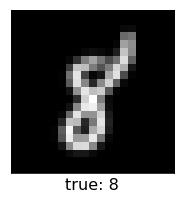

In [13]:
# View the training data.
training_index = 5
label_dict = dict({0: 3, 1: 7, 2: 8, 3: 9})
view_digit(X_train[training_index], label_dict[np.argmax(y_train[training_index])])